In [44]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
!pip install BertViz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 셀프 어텐션

In [46]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "time flies like an arrow"  # 5 글자짜리 문장을 사용 

In [47]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

vector: 768 means that each word or token in the BERT model is represented by a dense vector of 768 real-valued numbers  


In [48]:
from torch import nn 
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)  # 임베딩 층, 입력 ID가 nn.Embedding에 저장된 30522개 임베딩 벡터 중 하나에 매핑 
print("vocabulary size 30522, 각 벡터의 크기는 768")  # vocab.txt 파일을 보면 30522개의 토큰이 존재 
token_emb

vocabulary size 30522, 각 벡터의 크기는 768


Embedding(30522, 768)

In [49]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [50]:
nn.Embedding(config.vocab_size, config.hidden_size)  # 학습 데이터로부터 임베딩 벡터(context)를 생성

Embedding(30522, 768)

In [51]:
inputs_embeds = token_emb(inputs.input_ids)  # 토큰을 임베딩 벡터로 변환 
print("batch size, seq len, hidden dim")  # 시퀀스가 1, 시퀀스 길이는 5, 각 토큰의 임베딩 벡터는 768
inputs_embeds.size()

batch size, seq len, hidden dim


torch.Size([1, 5, 768])

In [52]:
inputs_embeds

tensor([[[ 0.4252, -0.7218,  0.2396,  ..., -1.2141, -0.3003, -0.1172],
         [ 1.3833, -0.6775, -0.1668,  ...,  0.7727,  0.0313, -0.2829],
         [ 0.3338, -0.0297,  0.5045,  ...,  0.1408, -1.6276, -0.1571],
         [-0.7560,  0.0248, -0.7643,  ...,  1.1596,  1.1483, -1.8267],
         [ 0.5302,  0.7960, -2.0727,  ..., -0.0796,  0.5773,  0.2941]]],
       grad_fn=<EmbeddingBackward0>)

In [53]:
import torch 
from math import sqrt 

query = key = value = inputs_embeds  # query와 key, value를 모두 inputs_emeds로 초기화 
dim_k = key.size(-1)  # 마지막 사이즈, 768
scores = torch.bmm(query, key.transpose(1, 2) / sqrt(dim_k))  # transpose는 전치 행렬, torch.bmm() 함수는 배치 행렬-행렬 곱셈을 수행 
# query는 5 * 768 이고 key.transpose는 768 * 5기 때문에 행렬곱을 하면 5 * 5 행렬이 나온다 
print("배치에 있는 샘플마다 5 x 5 사이즈의 어텐션 점수 행렬이 만들어짐")
scores.size()

배치에 있는 샘플마다 5 x 5 사이즈의 어텐션 점수 행렬이 만들어짐


torch.Size([1, 5, 5])

In [54]:
print(query) 
print(key)

tensor([[[ 0.4252, -0.7218,  0.2396,  ..., -1.2141, -0.3003, -0.1172],
         [ 1.3833, -0.6775, -0.1668,  ...,  0.7727,  0.0313, -0.2829],
         [ 0.3338, -0.0297,  0.5045,  ...,  0.1408, -1.6276, -0.1571],
         [-0.7560,  0.0248, -0.7643,  ...,  1.1596,  1.1483, -1.8267],
         [ 0.5302,  0.7960, -2.0727,  ..., -0.0796,  0.5773,  0.2941]]],
       grad_fn=<EmbeddingBackward0>)
tensor([[[ 0.4252, -0.7218,  0.2396,  ..., -1.2141, -0.3003, -0.1172],
         [ 1.3833, -0.6775, -0.1668,  ...,  0.7727,  0.0313, -0.2829],
         [ 0.3338, -0.0297,  0.5045,  ...,  0.1408, -1.6276, -0.1571],
         [-0.7560,  0.0248, -0.7643,  ...,  1.1596,  1.1483, -1.8267],
         [ 0.5302,  0.7960, -2.0727,  ..., -0.0796,  0.5773,  0.2941]]],
       grad_fn=<EmbeddingBackward0>)


In [55]:
scores  # 5 * 5 행렬 

tensor([[[ 3.1046e+01, -5.0389e-01, -2.0754e-01, -9.3592e-01,  4.2097e-01],
         [-5.0389e-01,  2.9882e+01, -3.0576e-01, -2.8686e-02,  1.4302e-02],
         [-2.0754e-01, -3.0576e-01,  2.6722e+01,  7.4182e-02, -3.3539e-01],
         [-9.3592e-01, -2.8686e-02,  7.4182e-02,  2.6813e+01,  6.2494e-02],
         [ 4.2097e-01,  1.4302e-02, -3.3539e-01,  6.2494e-02,  2.8027e+01]]],
       grad_fn=<BmmBackward0>)

In [56]:
# 소프트맥스 함수 적용
# torch.nn.functional은 딥러닝에 사용되는 다양한 함수 갖고 있음
import torch.nn.functional as F
weights = F.softmax(scores, dim=-1)  # softmax는 0~1사이의 값으로 모두 정규화, dim=-1은 마지막 차원 
print(weights)
weights.sum(dim=-1)  # 다 더하면 1이 됨 

tensor([[[1.0000e+00, 1.9857e-14, 2.6706e-14, 1.2891e-14, 5.0070e-14],
         [6.3593e-14, 1.0000e+00, 7.7526e-14, 1.0228e-13, 1.0677e-13],
         [2.0174e-12, 1.8287e-12, 1.0000e+00, 2.6739e-12, 1.7753e-12],
         [8.8887e-13, 2.2021e-12, 2.4407e-12, 1.0000e+00, 2.4124e-12],
         [1.0258e-12, 6.8304e-13, 4.8148e-13, 7.1677e-13, 1.0000e+00]]],
       grad_fn=<SoftmaxBackward0>)


tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [57]:
sum(weights[0][0])  # 행 다 더하면 1 

tensor(1., grad_fn=<AddBackward0>)

In [58]:
# 어텐션 스코어에 가중치 곱하기 
attn_outputs = torch.bmm(weights, value)  # weights는 5 * 5이고 value는 5 * 768이기 때문에
attn_outputs.shape  # 행렬곱을 하면 5 * 768의 행렬

torch.Size([1, 5, 768])

In [59]:
# 이태까지의 과정을 함수로 만들기 
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)  # query의 벡터 사이즈, 768
    scores = torch.bmm(query, key.transpose(1, 2) / sqrt(dim_k))  # attention score 계산
    weights = F.softmax(scores, dim = -1)  # 가중치 계산
    return torch.bmm(weights, value)  # attentoin score * 가중치 

# 멀티 헤드 어텐션

nn.Linear()  
y=wx+b 형태의 선형 변환을 수행  
nn.Linear는 파이토치에서 사용되는 선형 변환(linear transformation)을 수행하는 클래스로, Fully Connected Layer 또는 Dense Layer라고도 불림  
nn.Linear 클래스는 두 개의 행렬 가중치(weight)와 편향(bias)을 학습하며, 입력 텐서를 선형 변환하여 출력 텐서를 생성  
선형 변환은 입력 텐서와 가중치 행렬의 행렬 곱을 계산하고, 편향을 더하는 연산으로 이루어짐   
 
두 개의 인수를 받아들임  
*  in_features: 입력 텐서의 크기. 입력 텐서의 차원(dimension) 또는 특성(feature)의 수
*  out_features: 출력 텐서의 크기. 출력 텐서의 차원(dimension) 또는 특성(feature)의 수



In [60]:
#예시 

import torch
import torch.nn as nn

# feature가 3개인 input tensor 정의하기
input_tensor = torch.randn(1, 3)  

# input feature가 3개이고 output feature가 2개인 nn.Linear 레이어 생성
linear_layer = nn.Linear(3, 2)

# input tensor에 선형 변형 적용하기 
output_tensor = linear_layer(input_tensor)

# Print the output tensor and the learned weight and bias
print("Output tensor:", output_tensor)  # output feature 2개 
print("Weight matrix:", linear_layer.weight)  # (out_features, in_features)의 형태, 2 * 3     
print("Bias vector:", linear_layer.bias)  # (out_features, )의 형태, 1 * 2   


Output tensor: tensor([[0.4105, 0.9975]], grad_fn=<AddmmBackward0>)
Weight matrix: Parameter containing:
tensor([[-0.3541,  0.4437,  0.5462],
        [-0.0802,  0.1121,  0.4924]], requires_grad=True)
Bias vector: Parameter containing:
tensor([0.2345, 0.5515], requires_grad=True)


In [61]:
class AttentionHead(nn.Module):   # nn.Module은 모든 신경망 모듈의 베이스 클래스로 이 클래스를 subclass 해야 함 
    def __init__(self, embed_dim, head_dim):  # head_dim은 투영하려는 차원의 크기, embed_dim은 토큰의 임베딩 차원 
                                                # head_dim은 실전에서 embed_dim과 배수가 되게 설정
                                                # BERT에서는 어텐션 헤드가 12개여서 각 헤드의 차원은 768 / 12 = 64 
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)  # embed_dim의 input feature와 head_dim의 output feature를 가진 nn.Linear 레이어 생성, (768, 12)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
    def forward(self, hidden_state):  # hidden state = embedding vector 
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs 

In [62]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size  # 토큰의 임베딩 차원 (768)
        num_heads = config.num_attention_heads  # 투영하려는 차원의 크기 (12)
        head_dim = embed_dim // num_heads  # 각 헤드의 차원 (64)
        self.heads = nn.ModuleList(  # 모듈을 리스트로 보관 
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]  # 12개의 Head 만들기
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)  # (768, 768)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim = -1)  # 모듈의 heads의 정보를 이어붙임
        x = self.output_linear(x)  # (5, 768)
        return x 

In [63]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)  # 토큰을 임베딩 벡터로 변환한 것 넣기 
attn_output.size()  # 멀티-헤드 어텐션 행렬

torch.Size([1, 5, 768])

In [64]:
attn_output

tensor([[[-0.0029, -0.0548,  0.1533,  ...,  0.0738, -0.0348, -0.1684],
         [-0.0334,  0.0777,  0.2056,  ...,  0.1227, -0.1867, -0.2008],
         [-0.0099,  0.0414,  0.1429,  ...,  0.1026, -0.1558, -0.2370],
         [-0.0767, -0.0696,  0.1025,  ..., -0.0153, -0.1912, -0.1691],
         [ 0.0093, -0.0291,  0.1226,  ..., -0.0013, -0.0713, -0.1423]]],
       grad_fn=<ViewBackward0>)

In [65]:
from bertviz import head_view 
from transformers import AutoModel 

model = AutoModel.from_pretrained(model_ckpt, output_attentions = True)
sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors = 'pt')
attention = model(**viz_inputs).attentions 
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0]) 

head_view(attention, tokens, sentence_b_start, heads=[8])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

'flies'가 첫번째 문장에서는 가장 중요한 단어로 'arrow'를 꼽았고, 두번째 문장에서 'fruit'와 'banana'를 선택, 모델이 문맥에 따라 'flies'가 동사인지 명사인지 구별해냄 


# 피드 포워드 층 

피드 포워드 층: 완전 연결 신경망  
위치별 피드 포워드 층: 전체 임베딩 시퀀스를 하나의 벡터로 처리하지 않고 각 임베딩을 독립적으로 처리  
*   첫 번쨰 층의 크기를 임베딩의 네 배로 함 
*   GELU 활성화 함수 사용
*   대부분의 용량과 기억이 일어나며, 모델을 확장할 때 가장 많이 늘리는 부분   

The feed-forward component helps the transformer model learn and capture higher-level patterns and semantic information from the input sequence, enhancing its representational power.


활성화 함수란?   
활성화 함수란 인공 신경망에서 사용되는 은닉층을 활성화하기 위한 함수  
네트워크에 비선형성을 제공


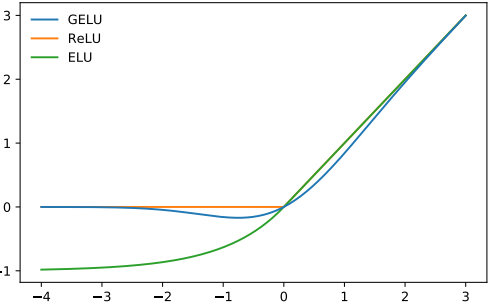

GELU 함수란? GELU(Gaussian Error Linear Unit)  
GELU(x) = 0.5 * x * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))  
성능이 좋아서 사용함 

intermediate layer: 입력 표현을 더 높은 차원의 공간으로 변형, self-attention 매커니즘과 output layer 사이에 위치함 

In [66]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)  # hidden size는 토큰의 임베딩 차원, intermediate_size는 피드 포워드 레이어의 차원
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)  # hidden_size는 768, intermediate_size는 3072
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)  # 정규화, 텐서의 랜덤한 서브셋 부분을 0으로 마스킹 함, 학습 중 네트워크에 노이즈를 도입하여 정규화, 학습할 때만 사용 
        return x 

In [68]:
feed_forward = FeedForward(config)
print(feed_forward)
ff_outputs = feed_forward(attn_outputs)  # 멀티-헤드 어텐션 행렬을 피드 포워드 
print(ff_outputs)
ff_outputs.size()  # 그대로 (5, 768) 텐서가 출력 

FeedForward(
  (linear_1): Linear(in_features=768, out_features=3072, bias=True)
  (linear_2): Linear(in_features=3072, out_features=768, bias=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
)
tensor([[[ 0.2977,  0.0568, -0.1634,  ...,  0.0727,  0.2736,  0.3416],
         [-0.1089, -0.2136,  0.1963,  ...,  0.1672,  0.0452,  0.0000],
         [-0.4844, -0.0915,  0.0909,  ..., -0.0598,  0.4320,  0.0018],
         [-0.2696, -0.2507, -0.0560,  ..., -0.0000,  0.1411, -0.2047],
         [ 0.1582,  0.3178,  0.0219,  ...,  0.0497,  0.0063,  0.0799]]],
       grad_fn=<MulBackward0>)


torch.Size([1, 5, 768])

# 층 정규화 추가하기 

층 정규화: 배치에 있는 각 입력을 평균이 0이고 분산이 1(단위 분산)이 되도록 정규화  
스킵 연결: 처리하지 않은 텐서를 모델의 다음 층으로 전달한 후 처리된 텐서와 더하기  


사후 층 정규화: 트랜스포머 논문에서 사용한 방법으로 스킵 연결 사이에 층 정규화를 놓기, gradient가 발산하는 경우가 생겨 처음부터 훈련하기 까다로움  
*  학습률 웜업: 훈련하는 동안 학습률을 작은 값에서 최댓값까지 점진적으로 증가시키기 

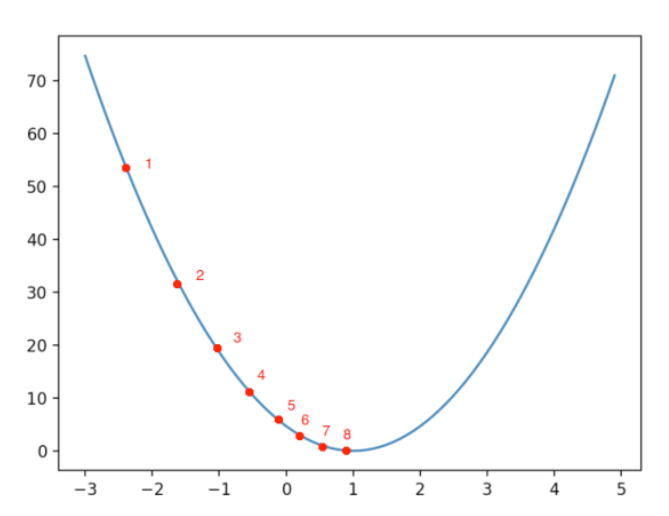

사전 층 정규화: 다른 논문에서 많이 사용, 스킵 연결 안에 층 정규화를 넣어 더욱 안정적이며 학습률 웜업이 필요하지 않음 

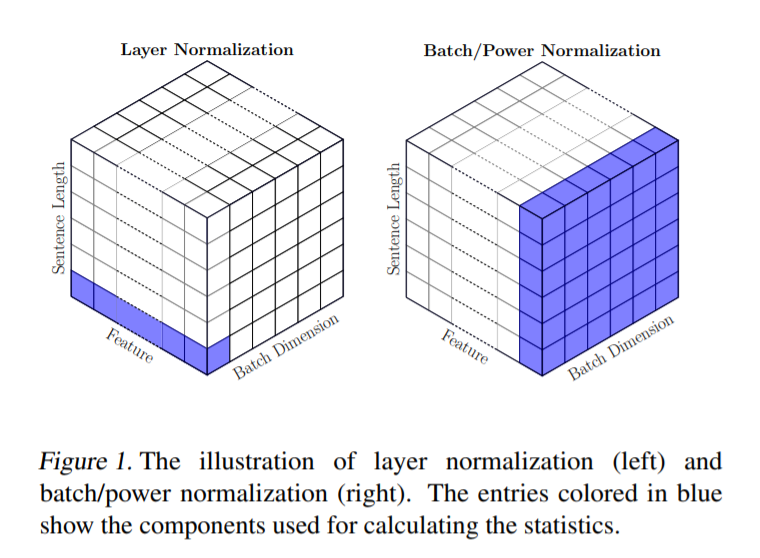

nn.LayerNorm  
레이어 정규화 실행하는 코드  
output = (input - mean) / sqrt(variance + eps) * gamma + beta  
학습을 안정화 시키고, 모델을 입력 스케일에 덜 민감하게 만듦 

In [69]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # 층 정규화를 적용하고 입력을 쿼리, 키 값으로 복사 
        hidden_state = self.layer_norm_1(x)
        # 어텐션에 스킵 연결을 적용
        x = x + self.attention(hidden_state)
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x 

In [70]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

# 위치 임베딩 
멀티 헤드 어텐션 층은 가중 합이기 때문에 토큰의 위치 정보가 사라져 위치 정보를 통합하는 방법  
벡터에 나열된 값의 위치 패턴으로 토큰 임베딩을 보강  
토큰 임베딩 층에 위치 임베딩을 통합하여 최종 임베딩 생성 

In [71]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__() 
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)  # nn.Embedding은 임베딩 층, (30522, 768)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)  # (512, 768)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps = 1e-12)  # 레이어 정규화 
        self.dropout = nn.Dropout() 

    def forward(self, input_ids): 
        # 입력 시퀀스에 대해 위치 ID 생성 
        seq_length = input_ids.size(1)  # 두번째 차원에 접근해서 input sequence의 길이를 정함 
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)  # seq_length만큼 만들고 index 0에 새로운 dimesion 추가 
        # 토큰 임베딩과 위치 임베딩 생성 
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # 토큰 임베딩과 위치 임베딩을 합치기
        embeddings = token_embeddings + position_embeddings 
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings 

In [72]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 5, 768])

# 완전한 트랜스포머 인코더 

In [73]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__() 
        self.embeddings = Embeddings(config)  # 위치 임베딩 
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])  # 12개의 인코더 레이어 생성해서 리스트로

    def forward(self, x):
        x = self.embeddings(x)  # input tensor x가 embedding layer로 보내짐 
        for layer in self.layers:  # TransformerEncoderLayer가 input tensor x에 차례대로 적용됨 
            x = layer(x)  # 
        return x 

In [74]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

# 분류 헤드 추가하기 
첫 번째 토큰을 예측에 사용하고 드롭아웃 층과 선형 층을 축라해 분류 예측을 만듦

In [75]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.encoder(x)[:, 0, :]  # 시퀀스의 첫 토큰 선택하기 
        x = self.dropout(x)
        x = self.classifier(x)  # config.num_labels에 적힌 아웃풋 라벨 갯수로 intermediate representation을 map하는 선형 레이어 
        return x 

In [76]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size() 

torch.Size([1, 3])

배치에 있는 각 샘플에 대해 출력 클래스마다 정규화되지 않은 로짓(정규화 이전의 모델 출력)이 반환됨 

# 디코더 

Masked Multi Head Self Attention Layer  
타임스텝마다 지난 출력과 예측한 현재 토큰만 사용하여 토큰을 생성   


Encoder-Decoder Attention Layer  
디코더의 중간 표현을 쿼리처럼 사용해서 인코더 스택의 출력 키와 값 벡터에 멀티 헤드 어텐션을 수행, 두 개의 다른 시퀀스에 있는 토큰을 연관짓는 방법을 학습, 디코더는 각 블록에서 인코더의 키와 값을 참조 

In [77]:
seq_len = inputs.input_ids.size(-1)  # 5
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)  # 하삼각행렬 만들기 
mask[0]

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [78]:
scores

tensor([[[ 3.1046e+01, -5.0389e-01, -2.0754e-01, -9.3592e-01,  4.2097e-01],
         [-5.0389e-01,  2.9882e+01, -3.0576e-01, -2.8686e-02,  1.4302e-02],
         [-2.0754e-01, -3.0576e-01,  2.6722e+01,  7.4182e-02, -3.3539e-01],
         [-9.3592e-01, -2.8686e-02,  7.4182e-02,  2.6813e+01,  6.2494e-02],
         [ 4.2097e-01,  1.4302e-02, -3.3539e-01,  6.2494e-02,  2.8027e+01]]],
       grad_fn=<BmmBackward0>)

In [79]:
scores.masked_fill(mask == 0, -float("inf"))  # 0을 음의 무한대로 바꾸어 어텐션 헤드가 미래 토큰을 엿보지 못하도록 하기 
                                            # 음의 무한대: 소프트맥스 함수를 적용할 때 어텐션 가중치가 모두 0이 됨 

tensor([[[ 3.1046e+01,        -inf,        -inf,        -inf,        -inf],
         [-5.0389e-01,  2.9882e+01,        -inf,        -inf,        -inf],
         [-2.0754e-01, -3.0576e-01,  2.6722e+01,        -inf,        -inf],
         [-9.3592e-01, -2.8686e-02,  7.4182e-02,  2.6813e+01,        -inf],
         [ 4.2097e-01,  1.4302e-02, -3.3539e-01,  6.2494e-02,  2.8027e+01]]],
       grad_fn=<MaskedFillBackward0>)

In [80]:
# 스케일드 점곱 어텐션 함수를 수정하여 마스킹 동작 추가 
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)  # query 의 벡터 사이즈 
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)  # attention score 계산 
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))  # 0을 -inf로 변환 
    weights = F.softmax(scores, dim=-1)  # 가중치 계산
    return weights.bmm(value)  # attention score * 가중치 